# Landsat Data Exploration

### Notes

Useful Links:
* http://www.sciencedirect.com/science/article/pii/S0034425700001693 (paper on change detection)
* https://spectraldifferences.wordpress.com/2014/05/27/arcsi/ (atmospheric correction using Py6s)
* https://landsat.gsfc.nasa.gov/landsat-and-the-private-tech-sector-direct-and-complementary-uses-of-imagery/ (landsat spatial and spectral performances)
* http://data.globalforestwatch.org/datasets/38d73f7882724318baf2be8bc2cd260a_8?orderByFields=st_area(shape)+ASC&geometry=-136.157%2C-23.484%2C-9.595%2C2.196 (Peru mining concession data)
* https://earthexplorer.usgs.gov/ (preferred site for Landsat data)

### Interesting References

* http://www.tandfonline.com/doi/abs/10.1080/01431160701352154
* http://www.mdpi.com/1424-8220/10/3/1967/htm

## Reading in Landsat Data

After doing some inital exploration of the Peru mining concessions data using the KML file on the site referenced above a particular study site was selected (Yanacocha mine, to the North of Cajamarca, Peru; https://goo.gl/maps/4tjEK2X5Dws).  This site comprises a very large mining complex with numerous apparently active excavations.  It appears to be a good place to start to gain an initial understanding of how mines evolve through time in the context of satellite imaging.  A total of 6 mostly cloud free scenes (< 10 % cloud cover) containing the ROI (path: 9; row: 65) were obtained from EarthExplorer, covering the time period July 2013 to November 2016 at roughly 6 month intervals.

In this section we know explore how to read in the raw landsat digital numbers from the L1B files.

In [1]:
from osgeo import gdal
from pyproj import Proj

import os 
import re

class LandsatReader(object):

    def __init__(self,
                 landsat_root,
                 line_sample_roi=None):
        self.root = landsat_root
        self.lsr = line_sample_roi
        self.dn_data_container = dict()

    def _get_file_list(self, data_file):
        files = os.listdir(os.path.join(self.root, data_file))
        self.file_list = [os.path.join(self.root, data_file, f)
                          for f in files if "TIF" in f if "BQA" not in f if "B8" not in f]

    def _read_arrays(self):
        for f in self.file_list:
            if "B" in f[-6:]:
                data_key = self._get_container_key_a(f)
            else:
                data_key = self._get_container_key_b(f)
            gdal.UseExceptions()
            ds = gdal.Open(f)
            self.dn_data_container[data_key] = self._extract_roi(ds)

    def _get_container_key_a(self, f):
        return re.search('B([0-9])', f).group()

    # fix this later
    def _get_container_key_b(self, f):
        return re.search('B([1][0-1])', f).group()

    def _extract_roi(self, ds):
        return ds.GetRasterBand(1).ReadAsArray(self.lsr['x1'],
                                               self.lsr['y1'],
                                               self.lsr['x2'] - self.lsr['x1'],
                                               self.lsr['y2'] - self.lsr['y1'])

    def read(self, data_file):
        self._get_file_list(data_file)
        self._read_arrays()


class LandsatGeoReader(object):
    
    def __init__(self,
                 landsat_root,
                 proj_param,
                 line_sample_roi=None):
        self.root = landsat_root
        self.proj_param = proj_param
        self.lsr = line_sample_roi
        self.geo_data_container = dict()

    def _get_file(self, data_file):
        files = os.listdir(os.path.join(self.root, data_file))
        self.f = [os.path.join(self.root, data_file, f) for f in files if "B2" in f][0]

    def _read_geo(self):
        gdal.UseExceptions()
        ds = gdal.Open(self.f)
        gt = self._get_transform(ds)
        grids = self._construct_grids()
        self.compute_geo(gt, grids)

    def _get_transform(self, ds):
        return ds.GetGeoTransform()

    def _construct_grids(self):
        # create grid the size of the image
        x = np.arange(self.lsr['x1'], self.lsr['x2'], 1)
        y = np.arange(self.lsr['y1'], self.lsr['y2'], 1)
        return np.meshgrid(x, y)

    def compute_geo(self, gt, grids):
        # compute eastings and northings
        x = gt[0] + grids[0] * gt[1] + grids[1] * gt[2]
        y = gt[3] + grids[0] * gt[4] + grids[1] * gt[5]

        # convert to wgs84
        landsat_proj = Proj(self.proj_param)
        lon, lat = landsat_proj(x, y, inverse=True)
        self.geo_data_container['lon'] = lon
        self.geo_data_container['lat'] = lat

    def _extract_roi(self, ds):
        return ds.GetRasterBand(1).ReadAsArray(self.lsr['x1'],
                                               self.lsr['y1'],
                                               self.lsr['x2'] - self.lsr['x1'],
                                               self.lsr['y2'] - self.lsr['y1'])

    def read(self, data_file):
        self._get_file(data_file)
        self._read_geo()


class LandsatMetaReader(object):

    def __init__(self,
                 landsat_root,
                 srf_path=''):
        self.root = landsat_root
        self.meta_data_container = dict()
        self._centre_wavelengths()

        if srf_path:
            self.srf_path = srf_path
            self._spectral_response_functions()

    def _centre_wavelengths(self):
        d = dict()
        keys = ["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B9"]
        values = [0.443, 0.482, 0.561, 0.655, 0.865, 1.609, 2.201, 1.373]  # microns
        for k, v in zip(keys, values):
            d[k] = v
        self.meta_data_container["centre_wavelengths"] = d

    def _spectral_response_functions(self):
        srf_dict = dict()
        for f in os.listdir(self.srf_path):
            if "_" in f:
                continue
            srf = self._read_srf(self.srf_path+f)
            f = f.split(".")
            srf_dict[f[0]] = srf
        self.meta_data_container['srf'] = srf_dict

    def _read_srf(self, srf_path):
        wvls = np.genfromtxt(srf_path, usecols=(0), delimiter='', dtype=float) / 1000  # convert to microns
        rsps = np.genfromtxt(srf_path, usecols=(1), delimiter='', dtype=float)
        srf = {}
        srf["wavelengths"] = wvls
        srf["responses"] = rsps
        return srf

    def _get_file(self, data_file):
        files = os.listdir(os.path.join(self.root, data_file))
        self.f = [os.path.join(self.root, data_file, f) for f in files if "MTL.txt" in f][0]

    def _read_meta(self):
        with open(self.f) as f:
            for line in f:
                listedline = line.strip().split(' = ')  # split around the = sign
                if len(listedline) > 1:  # we have the = sign in there
                    self.meta_data_container[listedline[0]] = listedline[1]

    def read(self, data_file):
        self._get_file(data_file)
        self._read_meta()

In [21]:
# Note: even for s. hem landsat image assign n. hem proj
# see http://gis.stackexchange.com/questions/9831/southern-hemisphere-projections-for-landsat-upsets-grass
landsat_path = "/Users/danielfisher/Projects/nrgi-mining-concessions/data/raw/Landsat/"
landsat_proj_param = "+init=EPSG:32617"  #http://spatialreference.org/ref/epsg/32618/
landsat_pixel_roi = {"x1": 3300,
                     "x2": 3900,
                     "y1": 2700,
                     "y2": 3200}

image_data_reader = LandsatReader(landsat_path, landsat_pixel_roi)
geo_data_reader = LandsatGeoReader(landsat_path, landsat_proj_param, landsat_pixel_roi)
meta_data_reader = LandsatMetaReader(landsat_path)

## Atmospherically Correcting Landsat Data

Acrsi looks like a good solution, but rather involved to get it working.  So this step can be postponed to later in the development process when we will better know whether such an preprocessing step is required. 

## Visualising a Single Scene

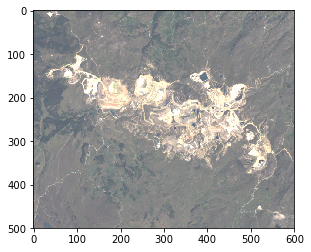

In [22]:
# ['B1', 'B2', 'B3', 'B4','B5', 'B6']  Landsat channels
# ['coastal', 'blue', 'green', 'red', 'nir', 'swir']  channel spectral region

import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure

%matplotlib inline

ls_filename = 'LC08_L1TP_009065_20130716_20170503_01_T1'

image_data_reader.read(ls_filename)
geo_data_reader.read(ls_filename)
meta_data_reader.read(ls_filename)

image_data = image_data_reader.dn_data_container 
geo_data = geo_data_reader.geo_data_container
meta_data = meta_data_reader.meta_data_container

im_shape = image_data['B5'].shape
rgb_composite = np.zeros((im_shape[0], im_shape[1], 3))

img432 = np.dstack((np.flipud(image_data["B4"]), np.flipud(image_data["B3"]), np.flipud(image_data["B2"])))
img432_ha = np.empty(img432.shape, dtype='uint16')
lims = [(1000, 14000), (1000, 14000), (1000, 14000)]
for lim, channel in zip(lims, range(3)):
    img432_ha[:, :, channel] = exposure.rescale_intensity(img432[:, :, channel], lim)
img432_ha[img432 == 0] = 65535
    
plt.imshow(img432_ha / 65535., interpolation='none')
plt.show()
    
    

## Visualising a Time Series

In [23]:
ls_filenames = os.listdir(landsat_path)
images = []
for ls_filename in ls_filenames:
    
    try:
        image_data_reader.read(ls_filename)
        geo_data_reader.read(ls_filename)
        meta_data_reader.read(ls_filename)
    except Exception, e:
        print "Could not open ", ls_filename, "with error", e
        
    image_data = image_data_reader.dn_data_container 
    geo_data = geo_data_reader.geo_data_container
    meta_data = meta_data_reader.meta_data_container

    im_shape = image_data['B5'].shape
    rgb_composite = np.zeros((im_shape[0], im_shape[1], 3))

    img432 = np.dstack((np.flipud(image_data["B4"]), np.flipud(image_data["B3"]), np.flipud(image_data["B2"])))
    img432_ha = np.empty(img432.shape, dtype='uint16')
    lims = [(1000, 14000), (1000, 14000), (1000, 14000)]
    for lim, channel in zip(lims, range(3)):
        img432_ha[:, :, channel] = exposure.rescale_intensity(img432[:, :, channel], lim)
    img432_ha[img432 == 0] = 65535
    images.append(img432_ha)

Could not open  .DS_Store with error [Errno 20] Not a directory: '/Users/danielfisher/Projects/nrgi-mining-concessions/data/raw/Landsat/.DS_Store'


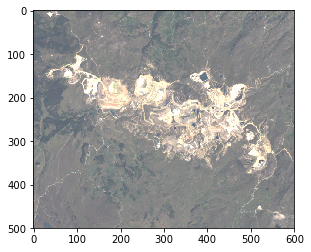

In [24]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig = plt.figure()

i = 0
im = plt.imshow(images[i] / 65535., animated=True)

def updatefig(i):
    im.set_array(images[i%len(images)] / 65535.)
    return [im,]

ani = FuncAnimation(fig, updatefig, blit=False)
HTML(ani.to_html5_video())

From the above it is clear that we need to project the data to a map before running the animation as in sensor coordinates we do not get consistent pixel locations between images.  Also seems to point to the need for atmospheric correction.

(500, 600)
(500, 600)
(500, 600)


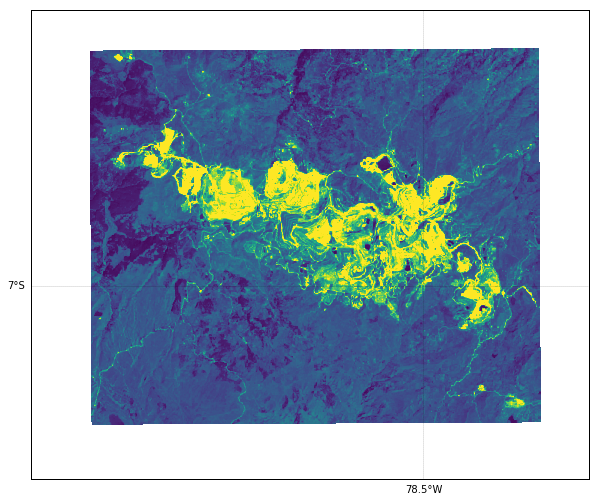

In [72]:
from mpl_toolkits.basemap import Basemap

fig = plt.figure(figsize=(10,10))

# set up the base map
m = Basemap(llcrnrlon=-78.6426, llcrnrlat=-7.07, urcrnrlon=-78.4403, urcrnrlat=-6.9)

i = 0
_map = m.pcolormesh(np.flipud(geo_data['lon']), np.flipud(geo_data['lat']), np.flipud(images[i][:,:,0]), latlon=True)
m.drawmapboundary()  # draw a line around the map region
m.drawparallels(np.arange(-7, -4, 0.5), linewidth=0.2, labels=[1, 0, 0, 0])  # draw parallels
m.drawmeridians(np.arange(-79, -76, 0.5), linewidth=0.2, labels=[0, 0, 0, 1])  # draw meridian

plt.show()